Creating figures for client trading reports was one the first things I had to do in Python, and probably what first got me excited about data science more broadly. In this post I want to write a little bit about what I see as the better way to approach data visualization with the `matplotlib` library, and also discuss how it helped me understand object-oriented programming.

Most of this post is based on my observations and experience. I've never had the chance to formally study data visualization, but I've probably written over two thousand scripts creating data visuals at this point (automating client reports was my first big task at SBI).

## A Primer on `matplotlib` and its Two Interfaces

Like a statistic, data visuals should provide an informative and intuitive summary of data.

I create most of my data visualizations in Python using the `matplotlib` library (and the `seaborn` library, which is a wonderful set of wrappers on `matplotlib`). Although I find the default ugliness  of `matplotlib` frustrating, its customizability is what keeps me coming back.

Unlike other visualization libraries such as the purist `ggplot2`, `matplotlib` [tries to cater to two programming paradigms](https://matplotlib.org/matplotblog/posts/pyplot-vs-object-oriented-interface/): functional and object-oriented. If you don't know what these mean, then don't worry; this post might be useful to you.

I'll start by creating some data that we'll use for creating our visuals.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy.random import MT19937, RandomState, SeedSequence
import seaborn as sns # Let's make it pretty

rs = RandomState(MT19937(SeedSequence(634)))
sns.set_style('darkgrid')

x = np.linspace(0, 10, 100) # 100 evenly spaced values 0 to 100
y = np.sin(x) + rs.normal(0, 0.1, 100)
print(x[:10], y[:10], sep='\n')

[0.         0.1010101  0.2020202  0.3030303  0.4040404  0.50505051
 0.60606061 0.70707071 0.80808081 0.90909091]
[-0.01858866 -0.03492486  0.13377902  0.38834817  0.4084214   0.61803973
  0.63883794  0.65699206  0.78248948  0.84992093]


Now that we have our `x` and `y` data, let's plot it.

I'll demonstrate creating the same figure using both approaches:

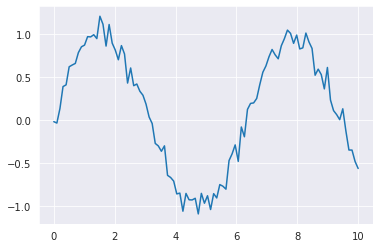

In [2]:
# Functional interface
plt.plot(x, y)

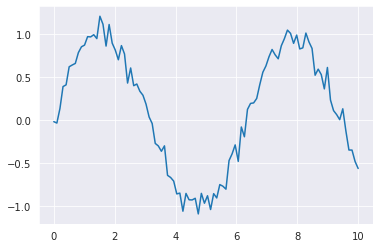

In [3]:
# OO interface
f = plt.figure()
ax = f.add_subplot(1, 1, 1) # nrows, ncols, loc
ax.plot(x, y)

What's going on? The functional interface requires fewer lines of code, but they seem to achieve the same thing.

It's clear what I'm _doing_ in the first figure. I call the `plt.plot` function on the x and y data and get a figure.

In the OO interface:
- I first create an empty "frame", `f`, with `plt.figure`.
- I can't draw directly onto this frame, so I use the `f.add_subplot` method to add a "canvas", `ax`.
- I use a method of the canvas to draw the data to this canvas: `ax.plot`

So the functional interface might seem like the better thing to use if you're a beginner or if you're just creating a quick figure, right? WRONG. But let me do justice to the functional interface first.

One line on one panel isn't particularly interesting. Some common things we might want to do:

- Set the size of the figure
- Add multiple panels
- Add titles to panels
- Add more lines/shapes to existing panels
- Align axes between subplots

And to be fair, this is possible with the functional interface. It just gets hacky very quickly.

Text(0.5, 1.0, 'Subplot 2')

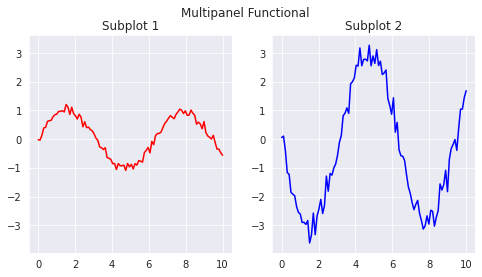

In [4]:
plt.figure(figsize=(8,4)) # Figure size
plt.suptitle('Multipanel Functional') # Create supertitle
plt.subplot(1, 2, 1) # Declare 1x2 grid, position 1
plt.plot(x, y, color='r') # Draw line onto subplot 1
plt.title('Subplot 1') # Add subplot title
plt.subplot(1, 2, 2, sharey=plt.gca()) # Declare new subplot, 1x2 grid, pos 2
                                   # Shared yaxis with previous subplot
plt.plot(x, -3*y, color='b') # Draw line onto subplot 2
plt.title('Subplot 2') # Add subplot title

Breaking it down call-by-call:

- `plt.figure`: Creates the "frame", but I use it just to set the size of the frame (and don't store the result)
    - Note we can do this with `plt.subplots`; I'll explain this below.
- `plt.suptitle`: A special function for adding a title at the "frame" level.
- `plt.subplot(1, 2, 1)`: Declare a subplot in a 1x2 grid, in position 1.
- `plt.plot`: Drawing the line onto the subplot I just created.
- `plt.title`: Adding a title to the subplot I just created.
- `plt.subplot(1, 2, 2, sharey=plt.gca())`:
    - Declare a subplot in a 1x2 grid, in position 2
    - Tell it to have a shared y-axis scale with `plt.gca()`, which captures the then-active subplot.

This is how you would achieve the same thing with the object-oriented interface:

Text(0.5, 1.0, 'Subplot 2')

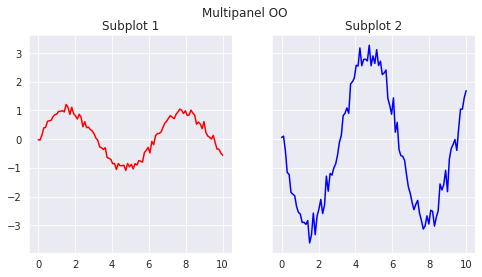

In [5]:
f, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
f.suptitle('Multipanel OO')
axs[0].plot(x, y, color='r')
axs[1].plot(x, -3*y, color='b')
axs[0].set_title('Subplot 1')
axs[1].set_title('Subplot 2')

Breaking it down:

- `plt.subplots` is a convenience function that returns both the "frame" and an array holding the subplots. We could use it in the functional example. but it would just replace the call to `plt.figure`.
- The figure-level title is called as a method of the figure object, `f`.
- `axs` is a 1x2 numpy array containing the subplots.
- I call subplot-level functions onto these subplots, corresponding to `ax.plot` and `ax.set_title`.

## Visualizations as Objects

In somewhat imprecise terms terms, _objects_ in object-oriented programming can be thought of as generic templates or blueprints to create specific instances of a more general class.

I think that the object-oriented approach `matplotlib` makes more sense because `matplotlib` itself organizes data visuals as nested collection of programming objects. Understanding this structure and the functionality of the individual objects helped me to understand the practicality of object-oriented programming.

The following is a simplification of the object hierarchy underlying `matplotlib` visuals:

- `Figure`: Top-level container for visuals. Some methods and properties include:
    - Figure-level text
    - Spacing/arrangement of subplots
    - Saving functionality
- `Axes`: Subplot container. Some methods and properties include:
    - Visual objects (lines, points, etc.)
    - Projections (Euclidean, polar, etc.)
    - Subplot-level text (titles)
    - Subplot-level legends
- `Xaxis/Yaxis`: Axis-level container. Methods and properties include:
    - Axis labelling
    - Tick locations

I'll illustrate what I mean by building a visual up from scratch, one more time. This time I'll introduce more of the functionality specific to each "level" of the visual.

Beginning with the `Figure` object. In addition to the features seen so far (figure title), the top-level container provides funcionality for arranging the individual subplots within the entire figure. This abstraction is convenient, because want to worry about the content of each plot and their placement relative to each other separately.

In [6]:
matplotlib.rc_file_defaults() #Remove seaborn default

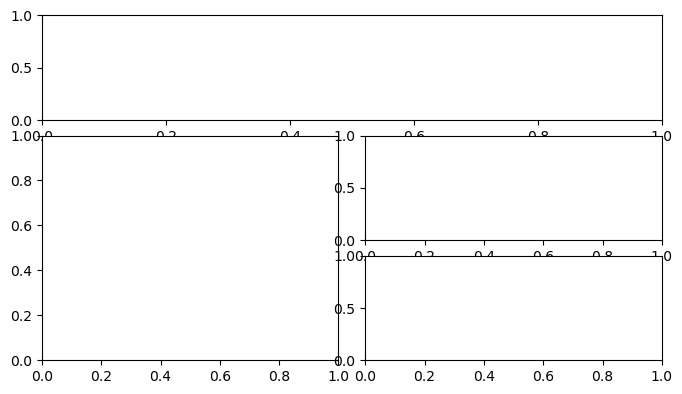

In [7]:
fig = plt.figure(figsize=(8,5)) # Instantiate the figure
fig.subplots_adjust(top=0.8, hspace=0.15, wspace=0.09) # top, height/widthspace
gs = fig.add_gridspec(3, 2) # Form 3x2 grid
ax1 = fig.add_subplot(gs[0:1, 0:2]) # Top, spanning full
ax2 = fig.add_subplot(gs[1:3, 0:1]) # Bottom-left
ax3 = fig.add_subplot(gs[1:2, 1:2]) # Middle-right
ax4 = fig.add_subplot(gs[2:3, 1:2], sharex=ax3) # Bottom-right

Working through this:

1. Instantiate an 8x5 figure, assign it to the variable `fig`
2. Set spacing of subplots. `top` creates space at the top, `h/wspace` creates space between subplots.
3. Create a 3x2 grid of subplots onto this figure. Assign to variable `gs`.
4. We use `gs` to specify where the subplots will be located. `ax1` spans the rows 0-1 (top row), and columns 0-2 (the full width).
5. Same logic for other three subplots; we also use `sharex` to fix `ax3` and `ax4` to have the same scale on their x-axis.

Let's add some visuals to this grid:

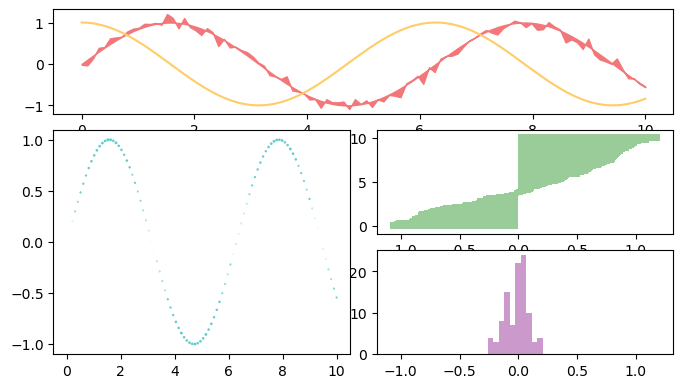

In [8]:
ax1.fill_between(x, y, np.sin(x), color='#f2777a')
ax1.plot(x, np.cos(x), color='#ffcc66', zorder=1)
ax2.scatter(x, np.sin(x), s=y**2, color='#66cccc')
ax3.barh(x, np.sort(y), color='#99cc99')
ax4.hist(y-np.sin(x), color='#cc99cc')

fig

You should notice that each function call _is a method of a subplot_. Unlike Figures, which set the frame, Subplots have plotting functionality as their methods. This also removes ambiguity about where you want the visual objects to be placed.

`matplotlib` has a lot of different functions for creating different kinds of polygons. I've tried to demonstrate a few of them here:

1. For a given x sequence, `fill_between` shades an area between two y sequences. This is the red shaded area in the top subplot. 
2. `plot` simply creates a line. This is the yellow line in the top subplot.
3. `scatter` creates dots. You can pass a sequence to the `s` parameter, which varies the size.
4. `barh` creates horizontal bars.
5. `hist` creates a histogram.

I haven't demonstrated some other subplot-level functions, such as setting titles or adding legends. This is for the sake of brevity.

Finally I want to showcase some axis-level methods. Again, these are things that make the most sense to call at the level they exist at; the individual axes.

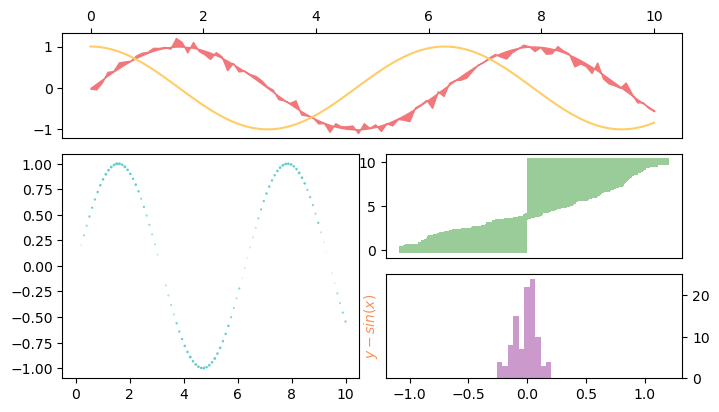

In [9]:
ax1.xaxis.set_ticks_position('top') # Move ticks to top
ax2.yaxis.set_ticks(np.linspace(-1, 1, 9)) # Set tick values
ax3.xaxis.set_visible(False) # Hide xaxis
ax4.yaxis.set_ticks_position('right') # Move ticks to right
ax4.yaxis.set_label_text('$y-sin(x)$', color='#f99157') # Add label - latex!

fig

1. `set_ticks_position` moves the ticks and their values.
2. `set_ticks` allows us to manually specify exact what values the ticks should take.
3. We can completely hide an axis by using `set_visible`
4. We can actually pass LaTeX to `matplotlib` and it will correctly render.

Admittedly, this approach of calling a method at the level it exists at can be tiresome if we want to conduct the same operation across every subplot (or axis). We can set contextual parameters `rcParams` to manage theming. For a full list of parameters, see `plt.rcParams.keys()`.

In the last example, I temporarily set the context to add a color scheme to the figure.

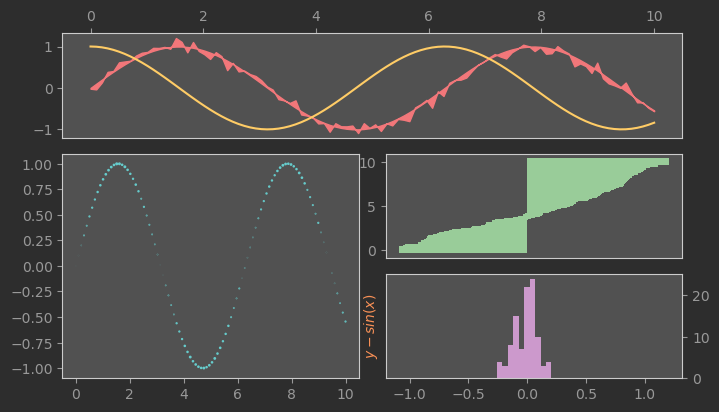

In [10]:
matplotlib.rc_file_defaults()
rc_params = {
    'figure.facecolor': '#2d2d2d',
    'axes.edgecolor': '#cccccc',
    'axes.facecolor': '#515151',
    'xtick.color': '#999999',
    'ytick.color': '#999999',
}
with plt.rc_context(rc_params):
    fig = plt.figure(figsize=(8,5)) # Instantiate the figure
    fig.set_facecolor('#2d2d2d') # Make the background blue
    fig.subplots_adjust(top=0.8, hspace=0.15, wspace=0.09) # top, height/widthspace
    gs = fig.add_gridspec(3, 2) # Form 3x2 grid
    ax1 = fig.add_subplot(gs[0:1, 0:2]) # Top, spanning full
    ax2 = fig.add_subplot(gs[1:3, 0:1]) # Bottom-left
    ax3 = fig.add_subplot(gs[1:2, 1:2]) # Middle-right
    ax4 = fig.add_subplot(gs[2:3, 1:2], sharex=ax3) # Bottom-right

    ax1.fill_between(x, y, np.sin(x), color='#f2777a')
    ax1.plot(x, np.cos(x), color='#ffcc66', zorder=1)
    ax2.scatter(x, np.sin(x), s=y**2, color='#66cccc')
    ax3.barh(x, np.sort(y), color='#99cc99')
    ax4.hist(y-np.sin(x), color='#cc99cc')

    ax1.xaxis.set_ticks_position('top') # Hide x-axis ticks and labels
    ax2.yaxis.set_ticks(np.linspace(-1, 1, 9)) # Change tick locations
    ax3.xaxis.set_visible(False)
    ax4.yaxis.set_ticks_position('right')
    ax4.yaxis.set_label_text('$y-sin(x)$', color='#f99157')

## Recap

I hope that if you came to this post not understanding _why_ object-oriented programming, these examples clarified instances where thinking of programming as building up specific instances of general classe can be effective.

There's tons of material I haven't covered on `matplotlib`, and I haven't explained at all how to start building your own classes in Python. If you have any questions, feel free to reach out to me on Twitter or otherwise! (Link in the sidebar, I hope).